# Introduction to CUDA programming 
* shallow tutorial showing first steps in CUDA
* refer to the [CUDA Programmining Guide](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html) for more details and API references. 

### Install CUDA on Colab
* using the CUDA plugin for *jupyter*

In [3]:
!git clone https://github.com/andreinechaev/nvcc4jupyter.git


Cloning into 'nvcc4jupyter'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (48/48), 8.29 KiB | 707.00 KiB/s, done.


In [4]:
!pip install ./nvcc4jupyter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./nvcc4jupyter
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4287 sha256=1fd075106bf81c52361ef518df7d41076ef43891b1d8e16079cc12b1e33bf16a
  Stored in directory: /tmp/pip-ephem-wheel-cache-muf24eu8/wheels/89/7c/f0/2290457aad138544426aef997b8456cf75b2b884118cd9f78e
Successfully built NVCCPlugin


In [5]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


### Test CUDA
Use ```%%cuda``` to mark CUDA cells

In [9]:
%%cuda --name hello.cu 
#include <iostream>
#include <stdlib.h>
#include <stdio.h>

//CUDA function
__global__ void cuda_hello(){
    printf("Hello World from GPU! %d\n", threadIdx.x*gridDim.x);
}

//C main
int main() {
    printf("Hello World from CPU!\n");
    cuda_hello<<<1,1>>>();
    cudaDeviceSynchronize(); 
    return 0;
}

'File written in /content/src/hello.cu'

In [10]:
#compile 
!nvcc -o /content/src/hello /content/src/hello.cu 

In [11]:
#run
!/content/src/hello

Hello World from CPU!
Hello World from GPU! 0


## Al larger example: adding vectors

### starting in plain C without GPU

In [12]:
%%cuda --name vec.cu 
#define N 10000000

void vector_add(float *out, float *a, float *b, int n) {
    for(int i = 0; i < n; i++){
        out[i] = a[i] + b[i];
    }
}

int main(){
    float *a, *b, *out; 

    // Allocate memory
    a   = (float*)malloc(sizeof(float) * N);
    b   = (float*)malloc(sizeof(float) * N);
    out = (float*)malloc(sizeof(float) * N);

    // Initialize array
    for(int i = 0; i < N; i++){
        a[i] = 1.0f; b[i] = 2.0f;
    }

    // Main function
    vector_add(out, a, b, N);
}

'File written in /content/src/vec.cu'

In [13]:
!nvcc -o /content/src/vec /content/src/vec.cu 

In [21]:
! /content/src/vec

### Exercise 1: write a function vector_sum
* that prints the sum over a vector
* use `printf`: `printf("The sum is: %d", s);`, where s is the variable holding the result

### now with cuda

In [16]:
%%cuda --name vec_gpu.cu 
#define N 10000000

__global__ void vector_add(float *out, float *a, float *b, int n) {
    for(int i = 0; i < n; i++){
        out[i] = a[i] + b[i];
    }
}

int main(){
    float *a, *b, *out; 

    // Allocate memory
    a   = (float*)malloc(sizeof(float) * N);
    b   = (float*)malloc(sizeof(float) * N);
    out = (float*)malloc(sizeof(float) * N);

    // Initialize array
    for(int i = 0; i < N; i++){
        a[i] = 1.0f; b[i] = 2.0f;
    }

    // Main function
    vector_add<<<1,1>>>(out, a, b, N);
}

'File written in /content/src/vec_gpu.cu'

In [17]:
!nvcc -o /content/src/vec_gpu /content/src/vec_gpu.cu 

In [25]:
!/content/src/vec_gpu

### Exercise 2: use vector_sum and compare the results


### Memory Management
Device memory management
CUDA provides several functions for allocating device memory. The most common ones are `cudaMalloc()` and `cudaFree()`. The syntax for both functions are as follow


```
cudaMalloc(void **devPtr, size_t count);
cudaFree(void *devPtr);
```



`cudaMalloc()` allocates memory of size count in the device memory and updates the device pointer devPtr to the allocated memory. `cudaFree()` deallocates a region of the device memory where the device pointer devPtr points to. They are comparable to `malloc()` and `free()` in C, respectively

Memory transfer
Transfering data between host and device memory can be done through cudaMemcpy function, which is similar to memcpy in C. The syntax of cudaMemcpy is as follow

`cudaMemcpy(void *dst, void *src, size_t count, cudaMemcpyKind kind)`

The function copy a memory of size count from src to dst. kind indicates the direction. For typical usage, the value of kind is either `cudaMemcpyHostToDevice` or cudaMemcpyDeviceToHost. There are other possible values but we will not touch them in this tutorial.

### Exercise 3: Completing vector addition
Allocate and deallocate device memory for array a, b, and out.

Transfer a, b, and out between host and device memory.

Quiz: Which array must be transferred before and after kernel execution ?


Example: Solution for array 'a'

```
void main(){
    float *a, *b, *out;
    float *d_a;

    a = (float*)malloc(sizeof(float) * N);

    // Allocate device memory for a
    cudaMalloc((void**)&d_a, sizeof(float) * N);

    // Transfer data from host to device memory
    cudaMemcpy(d_a, a, sizeof(float) * N, cudaMemcpyHostToDevice);

    vector_add<<<1,1>>>(out, d_a, b, N);

    // Cleanup after kernel execution
    cudaFree(d_a);
    free(a);
}
```

In [ ]:
#profile the solution
!nvprof /content/src/vec_gpu

## Going parallel
CUDA use a kernel execution configuration `<<<...>>>` to tell CUDA runtime how many threads to launch on GPU. CUDA organizes threads into a group called "thread block". Kernel can launch multiple thread blocks, organized into a "grid" structure.

The syntax of kernel execution configuration is as follows

`<<< M , T >>>`

Which indicate that a kernel launches with a grid of M thread blocks. Each thread block has T parallel threads.

### Exercise 4: Parallelizing vector addition using multithread
In this exercise, we will parallelize vector addition from tutorial 01 (vector_add.cu) using a thread block with 256 threads. The new kernel execution configuration is shown below.

`vector_add <<< 1 , 256 >>> (d_out, d_a, d_b, N);`

CUDA provides built-in variables for accessing thread information. In this exercise, we will use two of them: `threadIdx.x` and `blockDim.x`.

`threadIdx.x` contains the index of the thread within the block
`blockDim.x` contains the size of thread block (number of threads in the thread block).
For the vector_add() configuration, the value of `threadIdx.x` ranges from 0 to 255 and the value of `blockDim.x` is 256.

#### Parallelizing idea
Recall the kernel of single thread version in vector_add.cu. Notes that we modified the vector_add() kernel a bit to make the explanation easier.


```
__global__ void vector_add(float *out, float *a, float *b, int n) {
    int index = 0;
    int stride = 1
    for(int i = index; i < n; i += stride){
        out[i] = a[i] + b[i];
    }
}

```


In this implementation, only one thread computes vector addition by iterating through the whole arrays. With 256 threads, the addition can be spread across threads and computed simultaneously.

For the k-th thread, the loop starts from k-th element and iterates through the array with a loop stride of 256. For example, in the 0-th iteration, the k-th thread computes the addition of k-th element. In the next iteration, the k-th thread computes the addition of (k+256)-th element, and so on. Following figure shows an illustration of the idea.

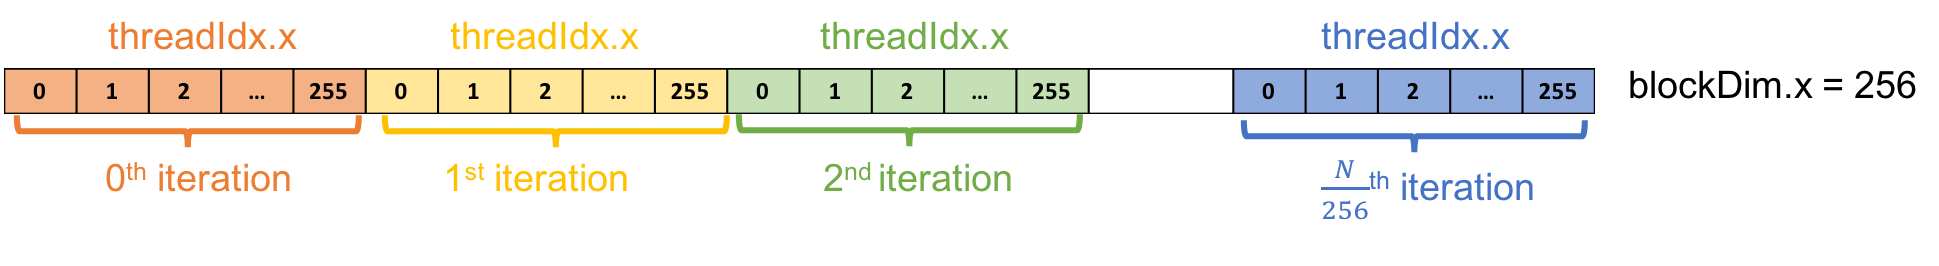



### EXERCISE 5: Try to implement this in vector_add_thread.cu

Copy vector_add.cu to vector_add_thread.cu
`$> cp vector_add.cu vector_add_thread.cu`
Parallelize vector_add() using a thread block with 256 threads.

Compile and profile the program

```
$> nvcc vector_add_thread.cu -o vector_add_thread
$> nvprof ./vector_add_thread
```






### Adding more thread blocks

CUDA GPUs have several parallel processors called Streaming Multiprocessors or SMs. Each SM consists of multiple parallel processors and can run multiple concurrent thread blocks. To take advantage of CUDA GPUs, kernel should be launched with multiple thread blocks. This exercise will expand the vector addition from exercise 1 to uses multiple thread blocks.

Similar to thread information, CUDA provides built-in variables for accessing block information. In this exercise, we will use two of them: `blockIdx.x` and `gridDim.x`.

`blockIdx.x` contains the index of the block with in the grid
`gridDim.x` contains the size of the grid

#### Parallelizing idea
Instead of using a thread block to iterate over the arrays, we will use multiple thread blocks to create N threads; each thread processes an element of the arrays. Following is an illustration of the parallelization idea.

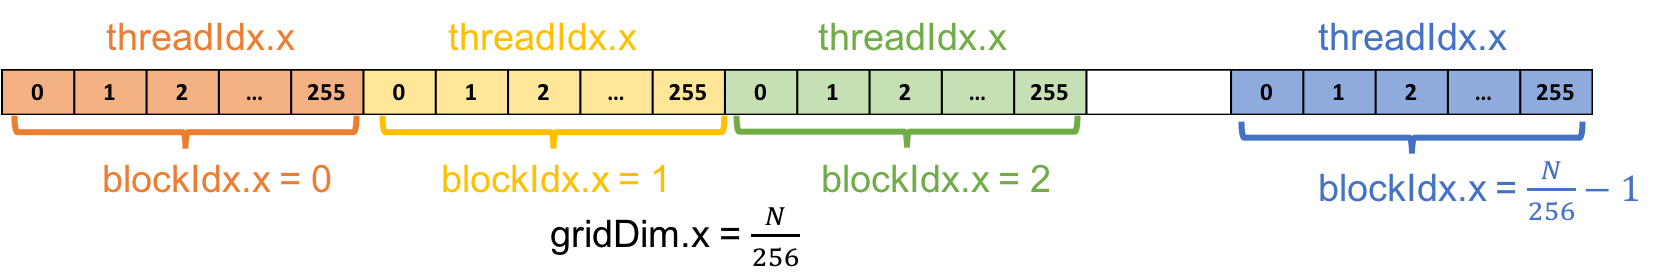

With 256 threads per thread block, we need at least N/256 thread blocks to have a total of N threads. To assign a thread to a specific element, we need to know a unique index for each thread. Such index can be computed as follow

`int tid = blockIdx.x * blockDim.x + threadIdx.x;`

### EXERCISE 6: Try to implement this in vector_add_grid.cu

### Compare results
A comparison of the results should look something like this:

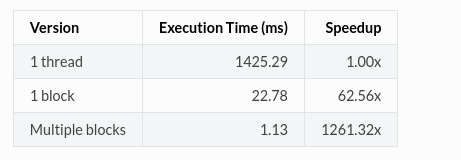